In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/MyDrive/TS

/content/gdrive/MyDrive/TS


In [7]:
!git clone https://github.com/GymMachineLearning/TimeSeriesAnalysis.git

Cloning into 'TimeSeriesAnalysis'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 22 (delta 3), reused 20 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 689.21 KiB | 2.58 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [8]:
!ls

TimeSeriesAnalysis


In [9]:
%cd TimeSeriesAnalysis/

/content/gdrive/MyDrive/TS/TimeSeriesAnalysis


In [10]:
!ls

coco  Data  MP.ipynb  README.md


In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [39]:
npz_file_path = "./Data/knees.npz"
data = np.load(npz_file_path)

keypoints_3d = data['reconstruction']
keypoints_3d[:,:,1] = -keypoints_3d[:,:,1]


In [13]:
print(keypoints_3d.shape)


(939, 17, 3)


In [14]:
knees = keypoints_3d[:,8,2]
print(knees.shape)

(939,)


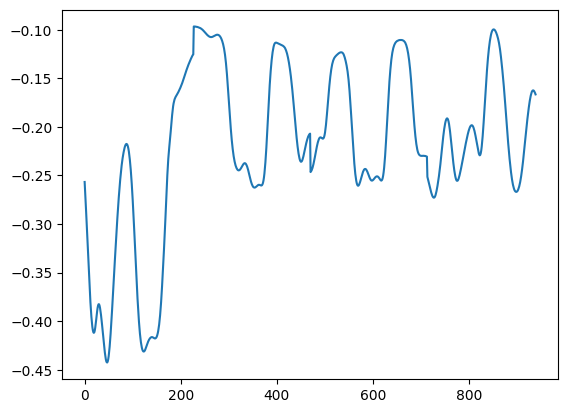

In [15]:
plt.plot(knees)

In [24]:
from scipy.signal import find_peaks

def segment_repetitions(keypoints_ts, exclusion_zone):
    right_hip_ts = keypoints_ts[:,8,2]
    left_hip_ts = keypoints_ts[:,11,2]
    reps, _ = find_peaks(right_hip_ts, distance = exclusion_zone)
    return reps

def cut_series_multidimensional(data, cut_indices):
    # Dodaj indeks początku (0) oraz końca tablicy (len(data))
    print(cut_indices)
    cut_indices = np.concatenate(([0], cut_indices, [len(data)]))  # Użyj np.concatenate

    print(cut_indices)
    # Tworzymy listę wycinków dla każdego segmentu
    segments = [data[cut_indices[i]:cut_indices[i+1],:] for i in range(len(cut_indices)-1)]

    return segments

def normalize_relative_to_start(series):
    """
    Funkcja normalizująca wielowymiarowy szereg względem początkowej wartości
    na każdym wymiarze.

    Parametry:
    series - 2D lub 3D ndarray, gdzie wymiary oznaczają (czas, wymiary, inne)

    Zwraca:
    Znormalizowany szereg czasowy, gdzie zmiany są względem początkowej wartości.
    """
    # Pobranie wartości początkowych (dla każdego wymiaru)
    initial_values = series[0, ...]  # Działa niezależnie od liczby wymiarów

    # Normalizacja przez odjęcie wartości początkowej
    normalized_series = series - initial_values

    return normalized_series

def get_segments_repetitions(keypoints_3d, exclusion_zone):
   reps = segment_repetitions(keypoints_3d, exclusion_zone)
   segments = cut_series_multidimensional(keypoints_3d, reps)
   return segments

[ 87 227 398 534 659 851]
[  0  87 227 398 534 659 851 939]
[ 87 227 398 534 659 851]


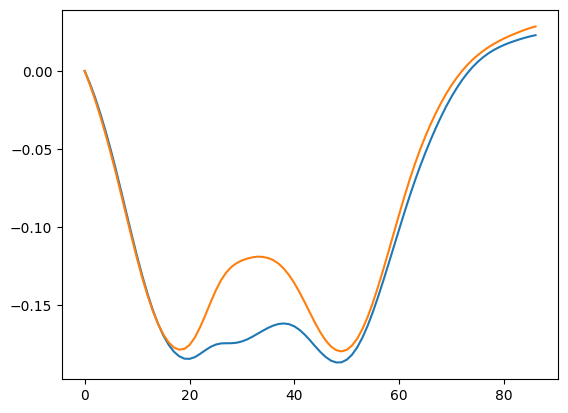

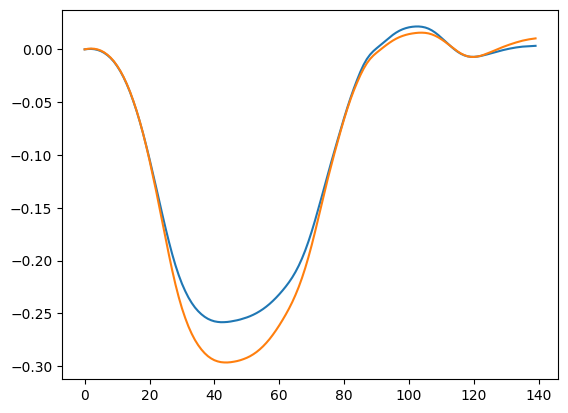

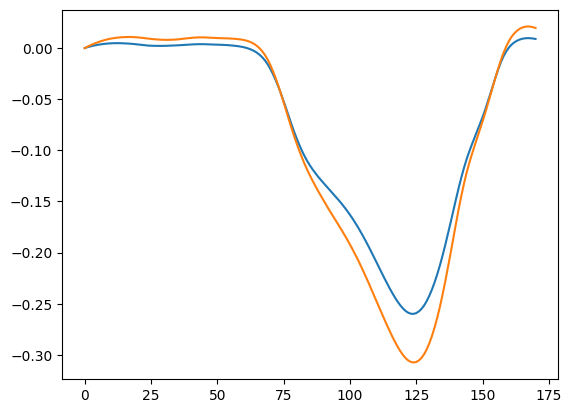

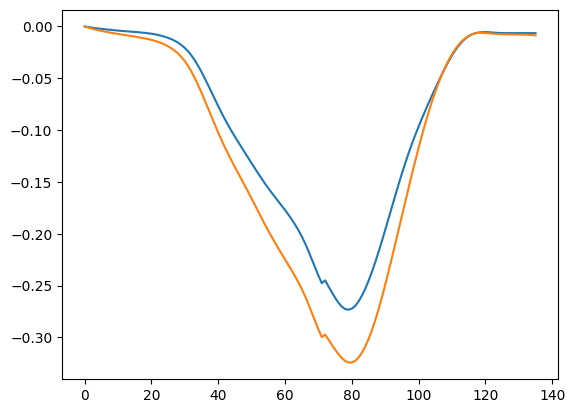

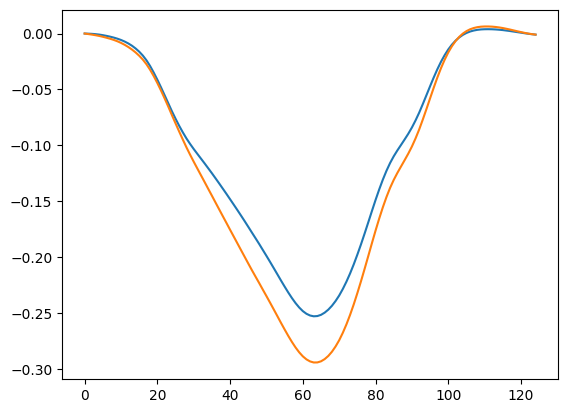

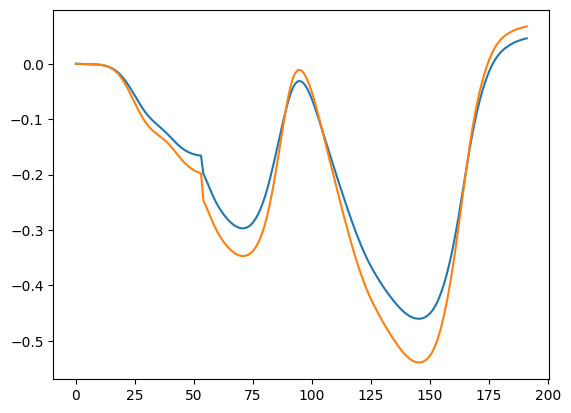

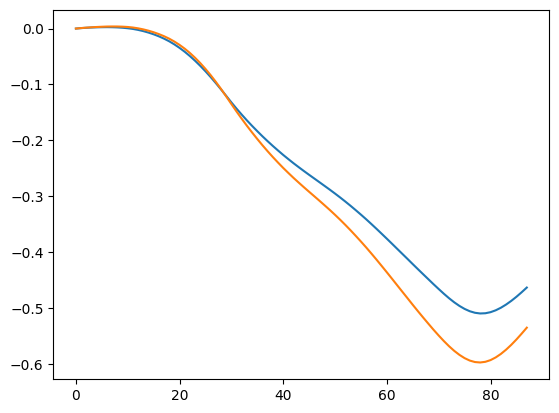

In [44]:
reps = segment_repetitions(keypoints_3d,100)
segments = cut_series_multidimensional(keypoints_3d, reps)
print(reps)
# for seg in segments:
#    plt.plot(seg[:,8,1])
#    plt.show()

for seg in segments:
   seg = seg[:,[8,9],1]
   seg = normalize_relative_to_start(seg)
   # print(seg.shape)
   plt.plot(seg)
   plt.show()
# print("wspolrzedna z")
# for seg in segments:
#    plt.plot(seg[:,[8,9],2])
#    plt.show()

[ 18 130 220 327]
[  0  18 130 220 327 352]
(18, 2)


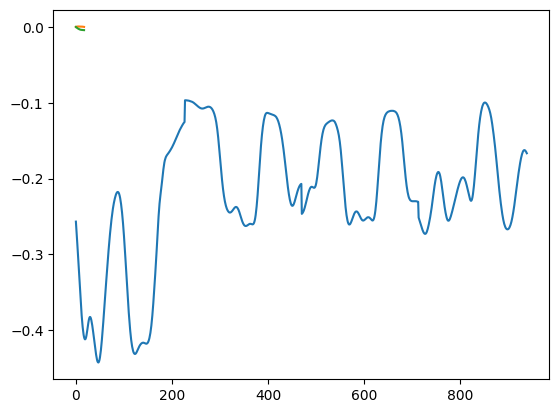

(112, 2)


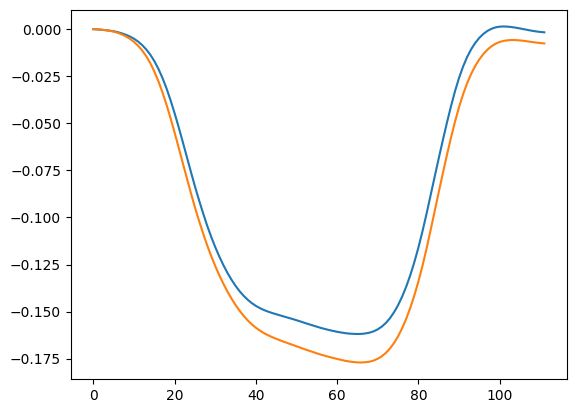

(90, 2)


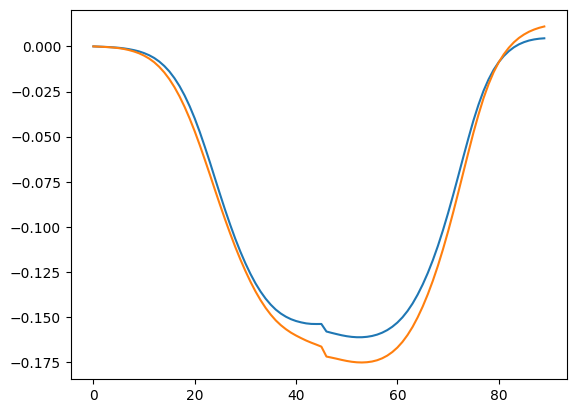

(107, 2)


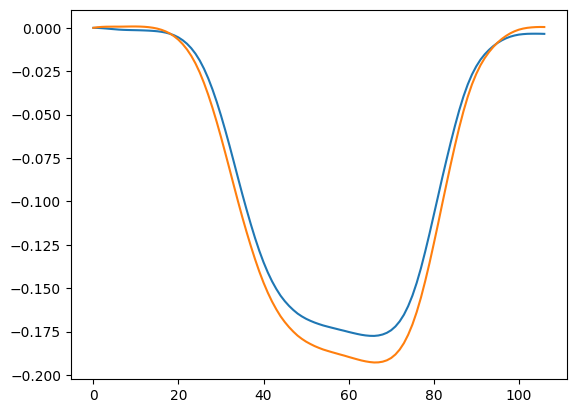

(25, 2)


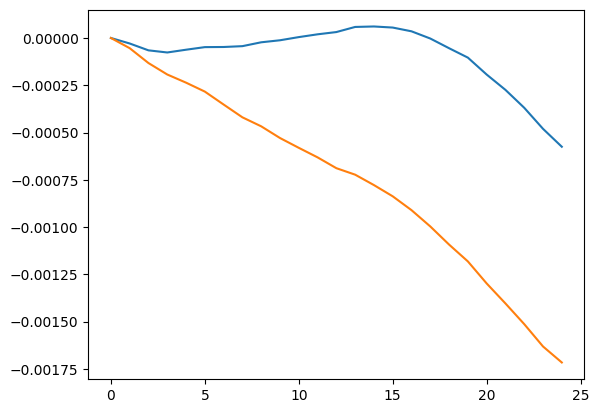

In [53]:
npz_file_path = "./Data/train.npz"
data = np.load(npz_file_path)

keypoints_3d_train = data['reconstruction']
keypoints_3d_train[:,:,1] = -keypoints_3d_train[:,:,1]
knees_train = keypoints_3d[:,8,2]
plt.plot(knees_train)

reps_train = segment_repetitions(keypoints_3d_train,80)
segments_train = cut_series_multidimensional(keypoints_3d_train, reps_train)

for seg in segments_train:
   seg = seg[:,[8,9],1]
   seg = normalize_relative_to_start(seg)
   print(seg.shape)
   plt.plot(seg)
   plt.show()

# Macierz profilu

In [21]:
! pip install stumpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 6.6 MB/s eta 0:00:00


(327, 2)


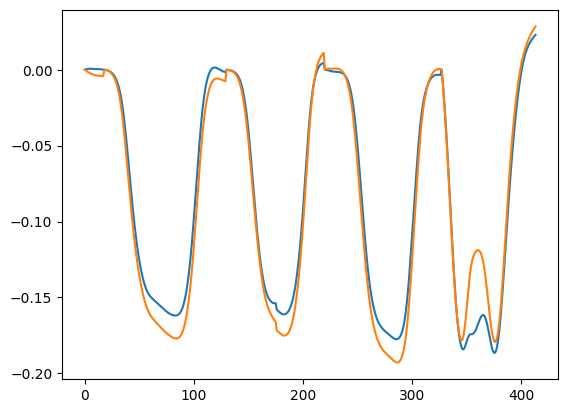

In [22]:
import stumpy

seg = segments_train[0]
seg = seg[:,[8,9],1]
data = normalize_relative_to_start(seg)

for seg in segments_train[1:-1]:
   seg = seg[:,[8,9],1]
   seg = normalize_relative_to_start(seg)
   #print(type(seg))
   data = np.concatenate((data, seg))

test_data = segments[0]
test_data = test_data[:,[8,9],1]
test_data = normalize_relative_to_start(test_data)
print(data.shape)
data = np.concatenate((data, test_data))
plt.plot(data)
# MP = stumpy.mstump()

(2, 365)


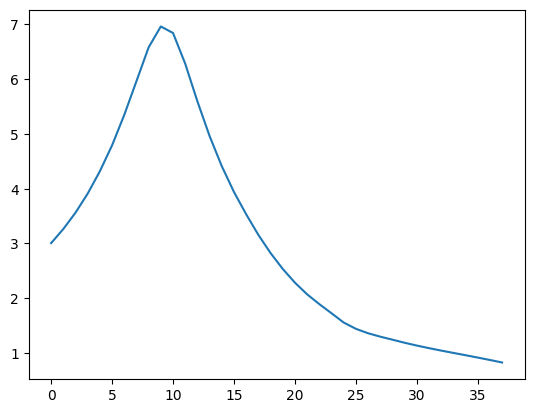

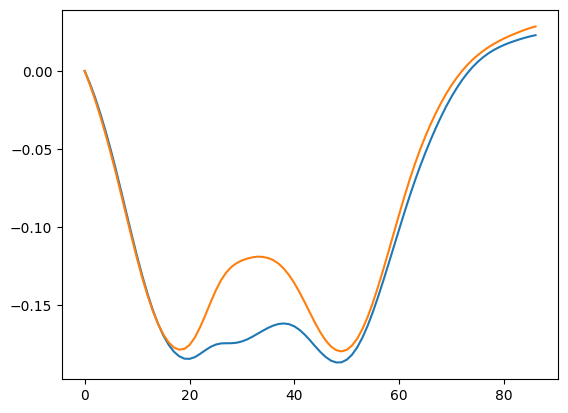

In [25]:
data = data.astype(dtype = "float64")
(P,I) = stumpy.mstump(data.T, 50)
print(P.shape)
plt.plot(P[1,327:])
plt.show()
plt.plot(test_data)

In [84]:
class SquatPoseEstimation:
  def __init__(__self__, keypoints_3d_ts, keypoints_3d_ts_train_repetitions):
    __self__.keypoints_3d_ts = keypoints_3d_ts
    __self__.reps = get_segments_repetitions(keypoints_3d, 100)
    __self__.reps_count = len(__self__.reps)
    __self__.keypoints_3d_ts_train_repetitions = keypoints_3d_ts_train_repetitions

  def analyze_repetition(__self__, rep_number):
    if rep_number >= __self__.reps_count:
      return None

    keypoints3d_ts_repetition = __self__.reps[0]
    __self__.analyze_legs(keypoints3d_ts_repetition)

# KEYPOINT_DICT = {
#     'nose': 0,
#     'left_eye': 1,
#     'right_eye': 2,
#     'left_ear': 3,
#     'right_ear': 4,
#     'left_shoulder': 5,
#     'right_shoulder': 6,
#     'left_elbow': 7,
#     'right_elbow': 8,
#     'left_wrist': 9,
#     'right_wrist': 10,
#     'left_hip': 11,
#     'right_hip': 12,
#     'left_knee': 13,
#     'right_knee': 14,
#     'left_ankle': 15,
#     'right_ankle': 16
# }


  def analyze_legs(__self__, keypoints3d_ts_repetition):
    right_leg_indices = [14, 12, 16]
    left_leg_indices = [13, 11, 15]
    coordinate = 0

    right_leg_y_test = keypoints3d_ts_repetition[:, right_leg_indices, coordinate]
    left_leg_y_test = keypoints3d_ts_repetition[:, left_leg_indices, coordinate]

    right_leg_y_train = None

    right_leg_y_train = __self__.keypoints_3d_ts_train_repetitions[0]
    right_leg_y_train = right_leg_y_train[:, right_leg_indices, coordinate]
    #right_leg_y_train = normalize_relative_to_start(right_leg_y_train)

    left_leg_y_train = None

    left_leg_y_train = __self__.keypoints_3d_ts_train_repetitions[0]
    left_leg_y_train = left_leg_y_train[:, left_leg_indices, coordinate]
    #left_leg_y_train = normalize_relative_to_start(left_leg_y_train)

    plt.plot(right_leg_y_test)
    plt.show()
    print("Nogi: ")
    plt.plot(left_leg_y_test)
    plt.show()

    plt.plot(right_leg_y_train)
    plt.show()
    print("Nogi: ")
    plt.plot(left_leg_y_train)
    plt.show()

    for train_seg in __self__.keypoints_3d_ts_train_repetitions[1:]:
      right_leg_y_train_seg = train_seg[:, right_leg_indices, coordinate]
      # right_leg_y_train_seg = normalize_relative_to_start(right_leg_y_train_seg)
      right_leg_y_train = np.concatenate((right_leg_y_train, right_leg_y_train_seg))

      left_leg_y_train_seg = train_seg[:, left_leg_indices, coordinate]
      # left_leg_y_train_seg = normalize_relative_to_start(left_leg_y_train_seg)
      left_leg_y_train = np.concatenate((left_leg_y_train, left_leg_y_train_seg))

      plt.plot(right_leg_y_train_seg)
      plt.show()
      print("Nogi: ")
      plt.plot(left_leg_y_train_seg)
      plt.show()

    left_leg_data = np.concatenate((left_leg_y_train, left_leg_y_test))
    left_leg_data = left_leg_data.astype(dtype = "float64")

    right_leg_data = np.concatenate((right_leg_y_train, right_leg_y_test))
    right_leg_data = right_leg_data.astype(dtype = "float64")

    test_data_start = len(left_leg_y_train)

    (P,I) = stumpy.mstump(left_leg_data.T, 50)
    print("Lewa noga")
    plt.plot(P[1, test_data_start:])
    plt.show()


    (P,I) = stumpy.mstump(right_leg_data.T, 50)
    print("Prawa noga")
    plt.plot(P[1, test_data_start:])
    plt.show()



[ 18 130 220 327]
[  0  18 130 220 327 352]
[ 87 227 398 534 659 851]
[  0  87 227 398 534 659 851 939]


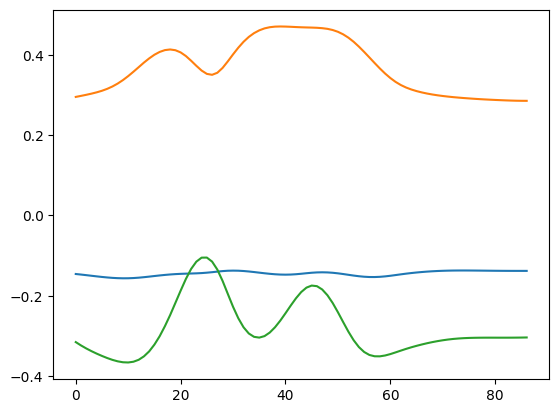

Nogi: 


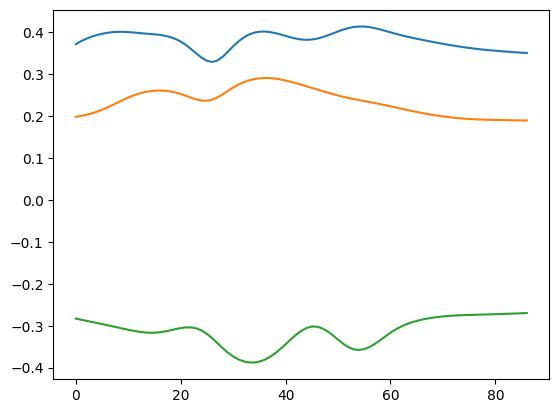

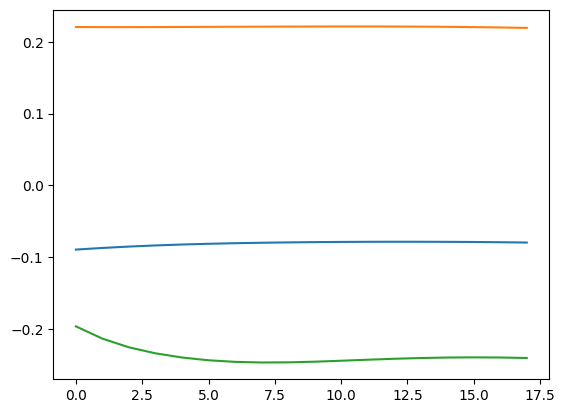

Nogi: 


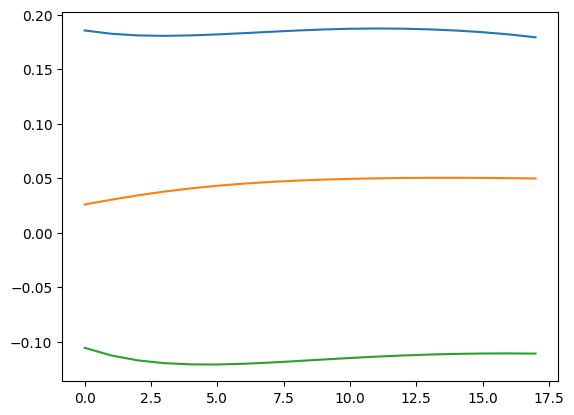

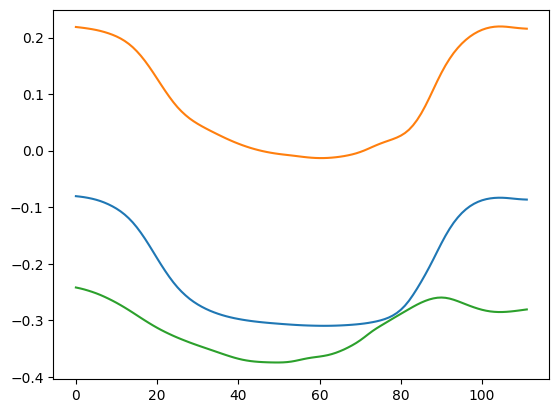

Nogi: 


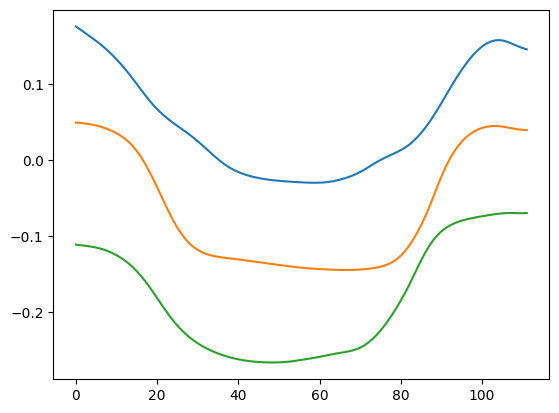

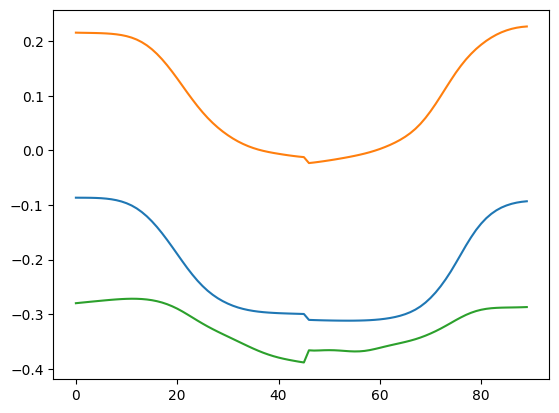

Nogi: 


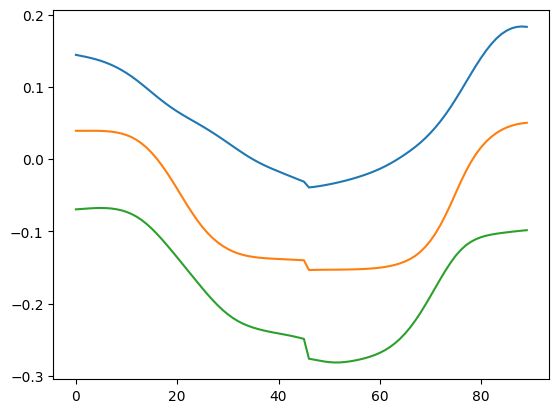

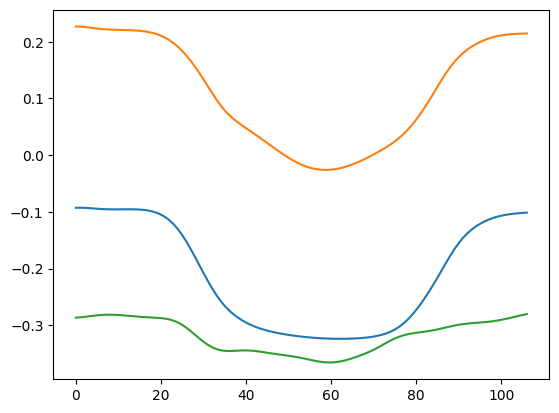

Nogi: 


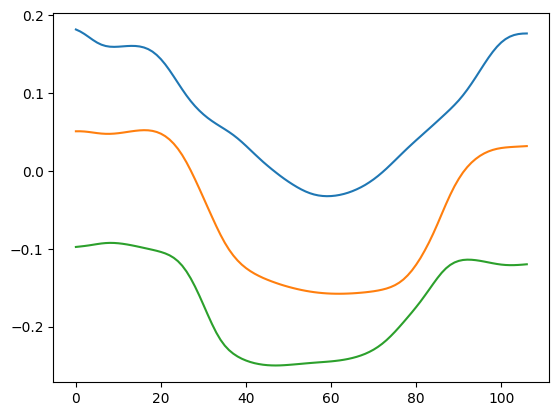

Lewa noga


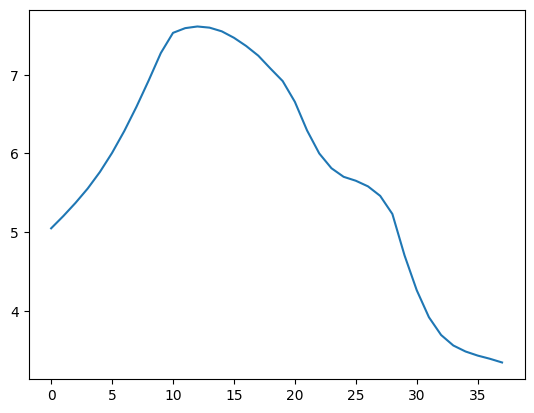

Prawa noga


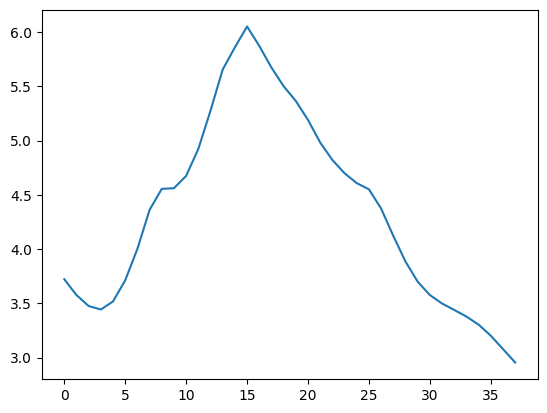

In [85]:
reps_train = segment_repetitions(keypoints_3d_train, 80)
segments_train = cut_series_multidimensional(keypoints_3d_train, reps_train)


Squat = SquatPoseEstimation(keypoints_3d, segments_train[:-1])
Squat.analyze_repetition(1)